# Домашнее задание 3

## Блок 1. Введение

В этом небольшом домашнем задании мы потренируемся работать с SARIMA-моделью. Для начала про данные. В этот раз они недельные. Будем прогнозировать на небольшой горизонт, 4 недели.

* target -- средневзвешенная по портам стоимость аммиака (usd/tonn) в некотором европейском регионе. Аммиак -- один из основных компонентов для производства азотных удобрений.
* oil -- стоимость фьючерса на нефть марки BRENT (usd)
* gas -- стоимость фьючерса на природный газ (usd)
* coal -- стоимость фьючерса на уголь (usd)
* corn, soybean, wheat, rice -- стоимость кукурузы, сои, пшеницы и риса соответственно (usd)

* usd_eur, usd_rub, usd_jpy, usd_cny -- курсы евро, рубля, йены и юаня к доллару
* usd_index -- индекс доллара

* cpy_us, cpi_china -- ВВП США и Китая


### 1.1) Загрузка данных. (0.5 балла)

Загрузите данные из файла data.csv. Сконвертируйте индексы в формат datetime. Обратите внимание на формат даты. При дефолтных параметрах конвертация произойдёт неверно. Далее используйте метод to_period, чтобы сконвертировать индексы, иначе ARIMA упадёт. В этот раз не будем разбивать на трейн и тест, а просто пройдёмся кросс-валидацией по всей выборке.



In [1]:
import pandas as pd
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import STL
import warnings 
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error
import numpy as np
from sktime.forecasting.naive import NaiveForecaster
from scipy.stats import boxcox
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA, ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)

In [2]:
data = pd.read_csv('data.csv', index_col = 0)
data.index = pd.to_datetime(data.index, dayfirst = True).to_period('W')

In [3]:
# заменяю пропуски последним досутпным значением.

ts = data.loc[data.index>data.target.isna().idxmin(),:]
ts.target = ts.target.fillna(method = 'ffill')

### 1.2) Визуальный анализ. (1 балл)

Изобразите временной ряд, его автокорреляции и частные автокорреляции. Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность?

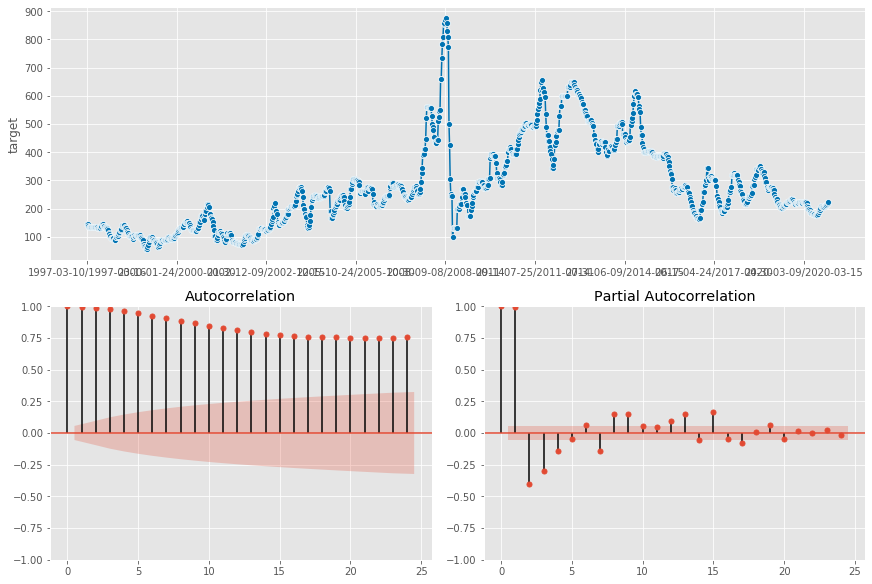

In [4]:
plot_correlations(ts.target);

корреляционная функция медленно убывает, что является признаком нестационарного ряда

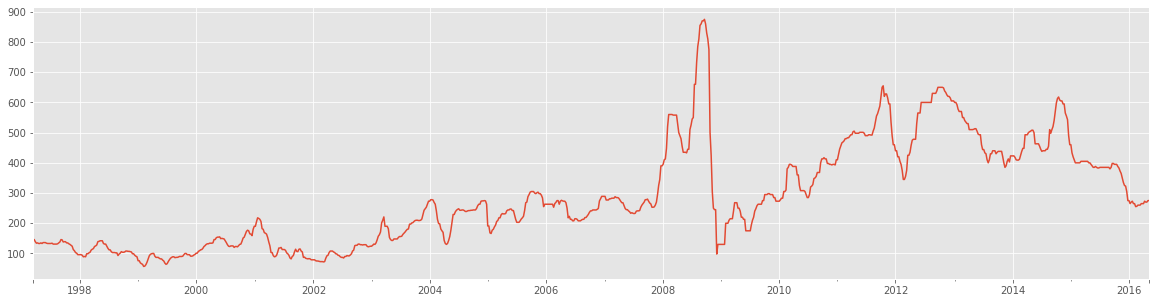

In [5]:
ts.target[:1000].plot()

предположим сезонную периодчиность k = 13. В среднем в году всречается 4 пика и спада. Выбранная периодчиность, отличная от 52, выбрана с целью экономии времени при обучении SARIMA модели.

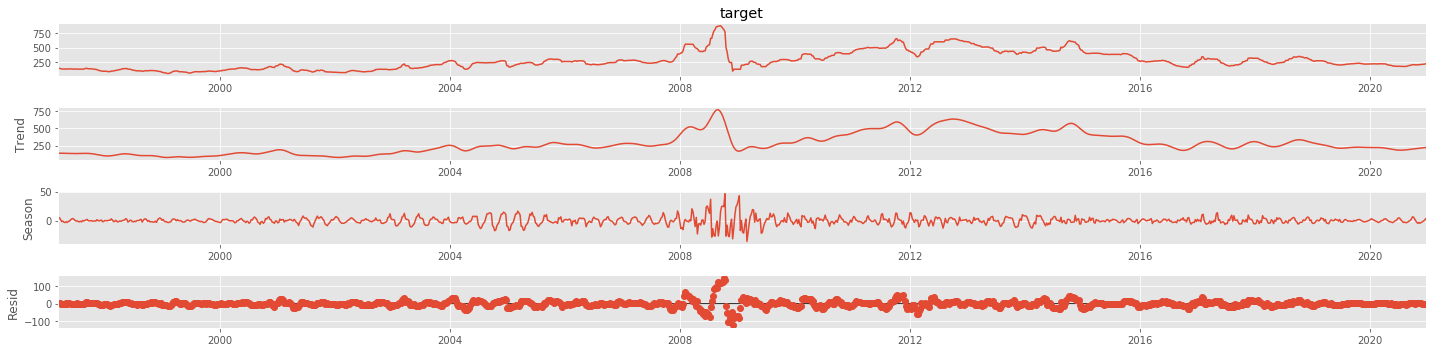

In [6]:
ts_ = ts.copy()
ts_.index = ts_.index.to_timestamp()
stl = STL(ts_.target, period = 13)
res = stl.fit()
res.plot();

явного тренда в ряде нет, заметная сезонность наблюдается на отрезке с 2008 года. Ряд является цикличным: сильный рост таргета в 2008 году сменился быстрым падением, в 2012 году ситуация повторилась, но в меньшем масштабе. Ряд не является стационарным из-за разности дисперсий до 2008 года и в 2008 и следующих за ним годах. 

## Блок 2. SARIMA

Сначала попробуем прогнозировать без внешних переменных.

### 2.1) Стационарность (1 балл)

Сначала примените сглаживающее преобразование (например, Бока-Кокса, или иное по своему усмотрению), если необходимо. 

Определите параметры d и D. Для этого воспользуйтесь STL-разложением и KPSS-тестом.

Детрендируйте ряд согласно параметрам d и D.

In [7]:
# использую преобразование Б-К для сглаживания ряда
ts.target, lambd = boxcox(ts.target)

In [8]:
seas_strength = max(0, 1 - res.resid.std()**2 / (res.resid.std()**2 + res.seasonal.std()**2))

seas_strength

0.0954696065157592

сила сезонности сильно ниже порогового значения, следовательно нет смысла переходить к сезонной рязности исходного ряда.

Соответсвенно, D = 0

In [9]:
# проверка ряда первых разностей на стационарность
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
    
kpss_test(ts.target)

KPSS Statistic: 3.0850696777198925
p-value: 0.01
num lags: 20
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [10]:
# ряд первых разностей
ts_diff = ts.target.diff().dropna()

In [11]:
kpss_test(ts_diff)

KPSS Statistic: 0.04327776794151358
p-value: 0.1
num lags: 16
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


По результатам kpss теста, взятие первой разности приводит ряд к стационарному виду.

Соответственно, d = 1

### 2.2) Анализ коррелограмм (1 балл)

Определите период сезонности, если она предполагается. Предположите, в каких границах лежат параметры p, q, P, Q. Для этого используйте коррелограммы.

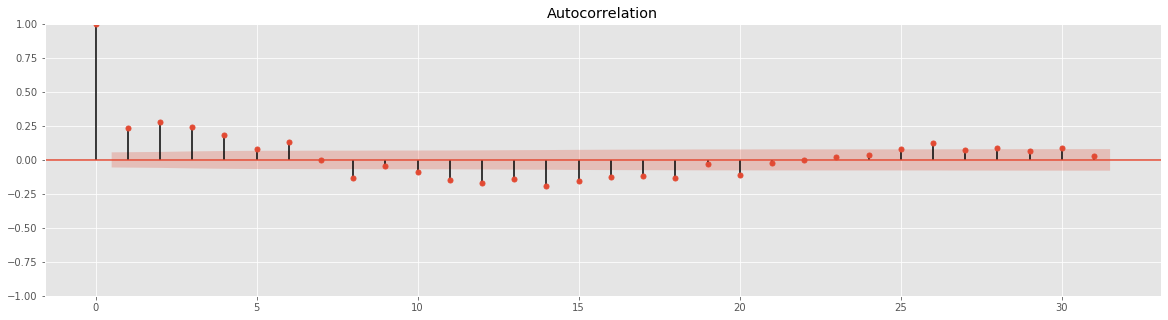

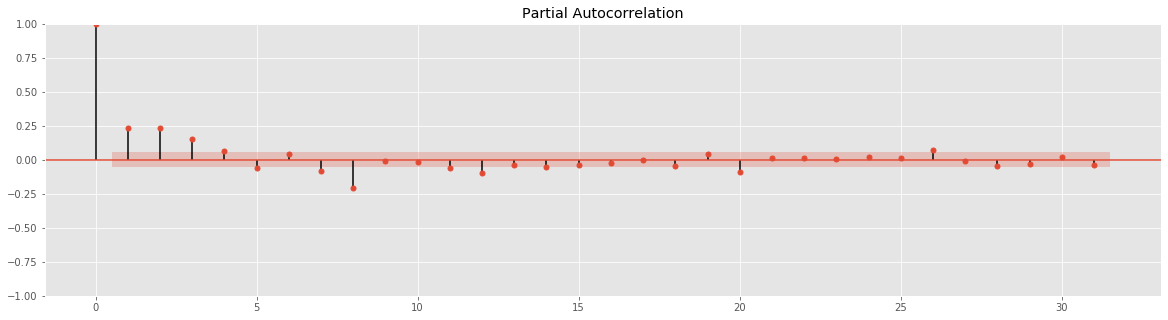

In [12]:
plot_acf(ts_diff);
plot_pacf(ts_diff);

По результатам графического анализа можно попытаться определить p и q. По графику автокорреляционной функции количество значимых лагов находится в пределах 4. Следовательно q <= 4. Аналогичное рассуждение по графику частной автокорреляционной функции приводит к выводу, что p <= 3.

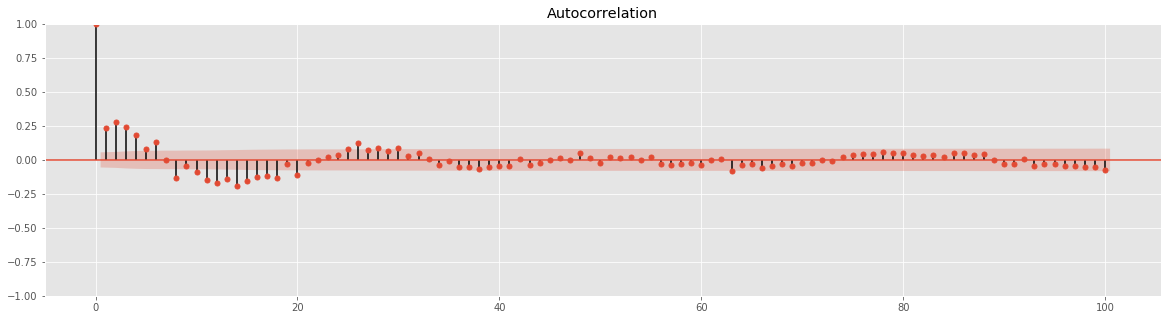

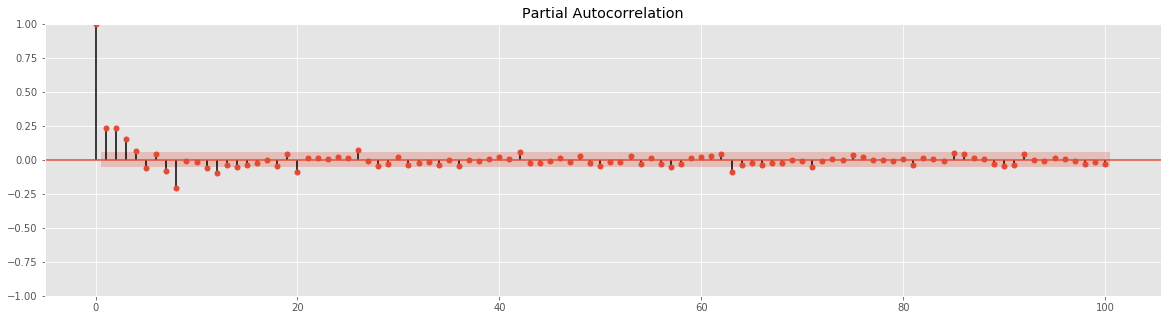

In [13]:
# для оценки сезонных составляющих рассмотри лаги, кратные размеру сезонности (k = 13)
plot_acf(ts_diff, lags = 100);
plot_pacf(ts_diff, lags = 100);

По графику автокорреляционной функции значимыми являются 13 и 26 лаги. По графику частной автокорреляционной функции - 13 лаг. 

Как итог, p <= 3, q <= 4, P = 1, Q = 2

### 2.3) Кросс-валидация (0.5 балла)

Сгенерируйте сетку параметров. Отберите на кросс-валидации наилучшую модель. Используйте метод скользящего окна. Ширина окна 150 (~3 года). Шаг -- 4 недели. Если получается слишком долго, возьмите шаг побольше, 10-15. Длина тестового периода -- 4 недели. Метрика -- MAE.

In [14]:
# чтобы перебор параметров работал, необходимо снизить p, q, P, Q.
d = 1
max_p = 2 # макс. возможное p
max_q = 2 # макс. возможное q

D = 0
max_P = 1
max_Q = 1 
sp = 13

# Генерируем сетку параметров. 
orders = []

for p in range(max_p+1):
    for q in range(max_q+1):
        orders.append((p, d, q))

seasonal_orders = []

for p in range(max_P+1):
    for q in range(max_Q+1):
        seasonal_orders.append((p, D, q, sp))

In [15]:
test_size = 4

fh = ForecastingHorizon(list(range(1, test_size+1)))

cv = SlidingWindowSplitter(
    start_with_window=True,
    initial_window=150,
    fh=fh,
    step_length=4)

forecaster = ARIMA(suppress_warnings=True)
param_grid = {"order" : orders, "seasonal_order":seasonal_orders}
gscv = ForecastingGridSearchCV(    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv, 
    scoring = MeanAbsoluteError(),
    n_jobs=-1)
gscv.fit(ts_diff)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4], dtype='int64', is_relative=True),
           initial_window=400, step_length=200),
                        forecaster=ARIMA(suppress_warnings=True), n_jobs=-1,
                        param_grid={'order': [(0, 1, 0), (0, 1, 1), (0, 1, 2),
                                              (1, 1, 0), (1, 1, 1), (1, 1, 2),
                                              (2, 1, 0), (2, 1, 1), (2, 1, 2)],
                                    'seasonal_order': [(0, 0, 0, 13),
                                                       (0, 0, 1, 13),
                                                       (1, 0, 0, 13),
                                                       (1, 0, 1, 13)]},
                        scoring=MeanAbsoluteError())

In [16]:
gscv.best_forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1241
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 946.146
Date:                Sat, 16 Apr 2022   AIC                          -1886.292
Time:                        20:11:19   BIC                          -1870.924
Sample:                             0   HQIC                         -1880.512
                               - 1241                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.559e-05      0.003      0.022      0.982      -0.007       0.007
ar.L1         -0.5282      0.005   -110.317      0.000      -0.538      -0.519
sigma2         0.0127   9.45e-05    134.705      0.000       0.013       0.013
===================================================================================
Ljung-Box (L1) (Q):                  34.53   Jarque-Bera (JB):            245269.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -1.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        71.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 2.4 Сравнение (0.5 балла)

Сравните ошибку на кросс-валидации для вашей модели, наивной модели и AutoARIMA. Не забудьте проверить, что границы поиска параметров AutoARIMA не меньше ваших. Получилось ли переиграть две последние модели? Совпали ли отобранная вами модель и модель из AutoARIMA?


In [17]:
# ошибка на кросс-валидации для моей модели
gscv.best_score_

0.031109995117319277

In [18]:
# ошибка на кросс валидации для наивного прогноза
forecaster = NaiveForecaster()
param_grid = {}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv, 
    scoring = MeanAbsoluteError(),
    n_jobs=-1)
gscv.fit(ts_diff)
gscv.best_score_

0.021313103924171007

In [19]:
# расчет ошибки AutoArima на кросс-валидации
forecaster = AutoARIMA(max_p=3, max_q=3, d=1, max_P=1, D=0, max_Q=1, sp=13)
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv, 
    scoring = MeanAbsoluteError(),
    n_jobs=-1)
gscv.fit(ts_diff)
gscv.best_score_

0.020062053826276467

In [20]:
gscv.best_forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1241
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 13)   Log Likelihood                1071.153
Date:                            Sat, 16 Apr 2022   AIC                          -2128.305
Time:                                    20:15:24   BIC                          -2092.445
Sample:                                         0   HQIC                         -2114.819
                                           - 1241                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.289e-05   7.85e-05     -0.546      0.585      -0.000       0.000
ar.L1          0.1032      0.010      9.881      0.000       0.083       0.124
ar.L2          0.2360      0.013     18.221      0.000       0.211       0.261
ma.L1         -0.9884      0.005   -195.867      0.000      -0.998      -0.978
ar.S.L13      -0.8729      0.107     -8.185      0.000      -1.082      -0.664
ma.S.L13       0.8210      0.118      6.968      0.000       0.590       1.052
sigma2         0.0102   7.41e-05    137.516      0.000       0.010       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):            365856.14
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -4.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        86.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

выбранная мной модель не смогла переиграть никакую из моделей. Параметры, подобранные АвтоАримой отличаются от выбранных на кросс-валидации. 

## Блок 3. SARIMAX

Маленькое вступление. Теперь мы попытаемся добавить в модель внешние регрессоры. Вообще говоря, модель SARIMAX -- это попытка объединить в одной модели всё сразу, что, ожидаемо, редко приводит к хорошему и устойчивому результату. И, что самое главное, такую модель ещё сложнее настраивать. Более эффективным с практической точки зрения было бы построить отдельно модель на внешних переменных (в духе моделей машинного обучения), а с автокорреляциями в её остатках побороться уже SARMA-моделью, но в случае линейной регрессии особой разницы не будет.  Но мы всё же разберём этот подход, чтобы понимать его сложности.

Если коротко про достоинства и недостатки этой модели:

Плюсы:

* Весьма гибкая модель, позволяет учесть кучу особенностей в данных
* Может быть неплоха, если нам нужны только одношаговые прогнозы и у нас не очень много переменных

Минусы:

* Ещё сложнее настраивать, чем SARIMA
* Рекурсивна. Отсюда проблемы с многошаговым прогнозированием и накоплением ошибки
* При большом количестве экзогенных переменных и малом числе наблюдений может быть неустойчива

### 3.1) Выбор внешней переменной (1 балл)

Из всех внешних факторов выберите какую-нибудь переменную, которая будет удовлетворять тесту Гранжера. Кратко опишите причинно-следственную связь, которая может возникать между этими переменными. 

По дефолту в следующих пунктах в качестве фичи можете использовать первый лаг отобранной переменной. Если захотите взять ещё лаги, это конечно хорошо, но придётся аккуратно разбираться с прогнозом каждого лага, поэтому предлагается не усложнять себе жизнь.

In [21]:
# газ является сырьем для производства аммиака. 
#Следовательно, цена последнего напрямую зависит от цен фьючерса на газ, но не наоборот.

# гипотеза о том, что газ не помогает в прогнозировании аммиака отвергается
columns = ts.loc[:,('target','gas')]
target_to_gas = grangercausalitytests(columns, maxlag = [20])


Granger Causality
number of lags (no zero) 20
ssr based F test:         F=2.4582  , p=0.0004  , df_denom=1181, df_num=20
ssr based chi2 test:   chi2=50.8705 , p=0.0002  , df=20
likelihood ratio test: chi2=49.8402 , p=0.0002  , df=20
parameter F test:         F=2.4582  , p=0.0004  , df_denom=1181, df_num=20


In [22]:
# гипотеза о том, что аммиак не помогает в прогнозировании цены на газ не отвергается
columns = ts.loc[:,('gas','target')]
target_to_gas = grangercausalitytests(columns, maxlag = [20])


Granger Causality
number of lags (no zero) 20
ssr based F test:         F=1.1042  , p=0.3380  , df_denom=1181, df_num=20
ssr based chi2 test:   chi2=22.8511 , p=0.2962  , df=20
likelihood ratio test: chi2=22.6400 , p=0.3068  , df=20
parameter F test:         F=1.1042  , p=0.3380  , df_denom=1181, df_num=20


In [23]:
# вектор газа сдвигаем с единичным лагом. 
ts = data.loc[:,('target', 'gas')]
ts.loc[:, 'gas'] = ts.loc[:, 'gas'].shift()
ts = ts.dropna()

### 3.2) Фильтрация (1.5 балла)

Использование внешней переменной несколько осложняет подбор параметров SARIMA. Дело в том, что если ряды y и x одинакового порядка интеграции, то при использовании их в одном уравнении тренды могут взаимно сократиться:

$$ y_t = SARIMA + \alpha_1 x_{t-1}$$

$$ y_t - \alpha_1 x_{t-1} = SARIMA $$

При некоторых обстоятельствах разница  $ y_t - \alpha_1 x_{t-1} $ может дать стациионарный ряд. В литературе такая ситуация называется коинтеграцией. Есть много не слишком внятных статей на эту тематику. Особенно туманны выводы для случаев, когда коинтеграции нет. Но в целом всё это скорее разговор о теоретических характеристиках оценок коэффициентов моделей. В контексте прогнозирования это обычно не учитывают и каких-то внятных рекомендаций тоже нет, либо они не распространены. Поэтому единственный адекватный способ узнать это влияние -- построить регрессию (либо SARIMA((0,0,0), (0,0,0)) с экзогенной переменной), а потом посмотреть, как устроены остатки, и на основе них сделать выводы о параметрах SARIMA. 

В большинстве случаев люди, конечно, так не заморачиваются. Берут AutoARIMA либо достаточно широкие границы на кросс-валидации и просто ждут. Но мы же учёные, нам так неинтересно!

Здесь уже видно, что в таком виде SARIMAX-модель банально аналогична тому, что мы оцениваем две модели: линрег, а на его остатки навешиваем SARIMA. Единственный плюс в том, что мы сможем это объединить в одном уравнении.


Собственно, задание: постройте SARIMAX((0,0,0), (0,0,0))  с выбранной экзогенной переменной (либо просто линрег y_t на x_{t-1}, будет то же самое). Будьте внимательны, дефолтный параметры класса ARIMA -- не совсем то, что мы просим. Далее получите остатки на трейне этой одношаговой модели.

In [24]:
# обучаю линейную модель с константой.
X,y = ts.gas[:,None], ts.target
model = sm.OLS(y, X).fit()
pred = model.predict()
resid = y - pred

### 3.3) Анализ остатков (1 балл)

Остатки из предыдущего пункта -- это по сути y, фильтрованный относительно выбранной экзогенной переменной. Сделайте выводы относительно параметров d и D, а также относительно границ параметров p, q, P, Q.

In [25]:
stl = STL(resid, period = 13)
res = stl.fit()
seas_strength = max(0, 1 - res.resid.std()**2 / (res.resid.std()**2 + res.seasonal.std()**2))
seas_strength # не нужно переходить к сезонной разности

0.16936459552669259

In [26]:
kpss_test(resid)

KPSS Statistic: 2.860247896298479
p-value: 0.01
num lags: 20
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [27]:
resid_dif = resid.diff().dropna()
kpss_test(resid_dif) # понадобилась одна разность, чтобы сделать ряд стационарным

KPSS Statistic: 0.025814757109055415
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


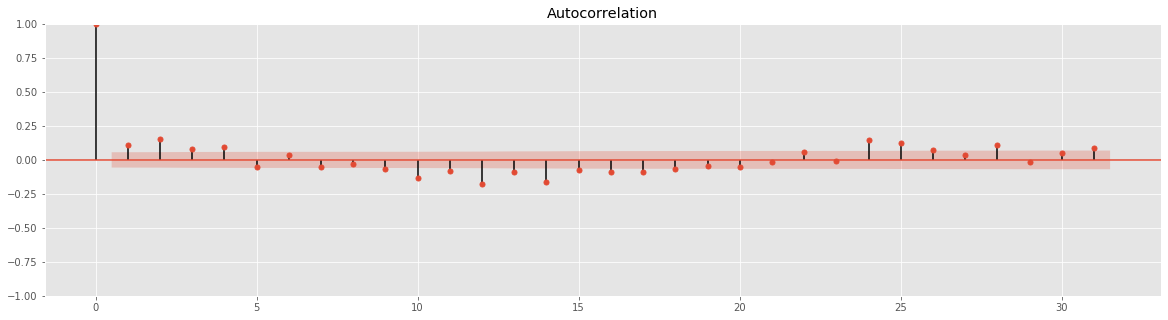

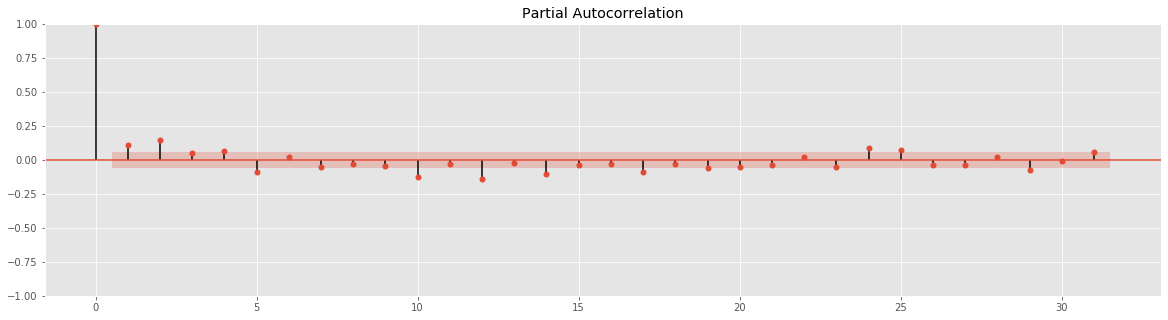

In [28]:
plot_acf(resid_dif) # max_q = 2
plot_pacf(resid_dif); # max_p = 2

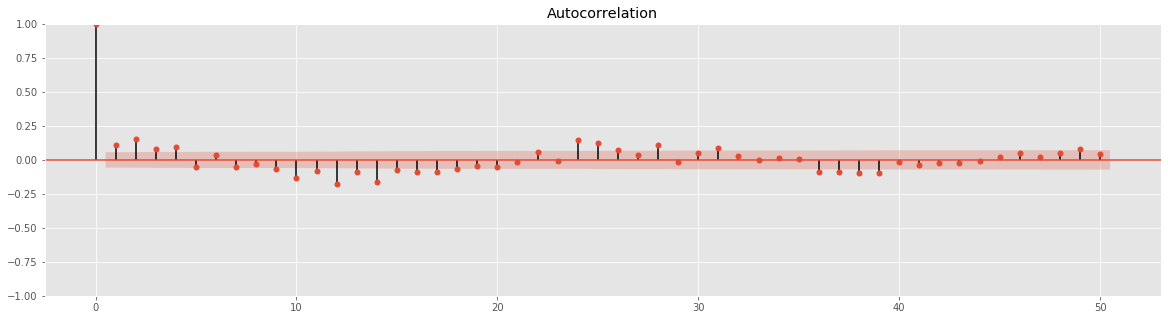

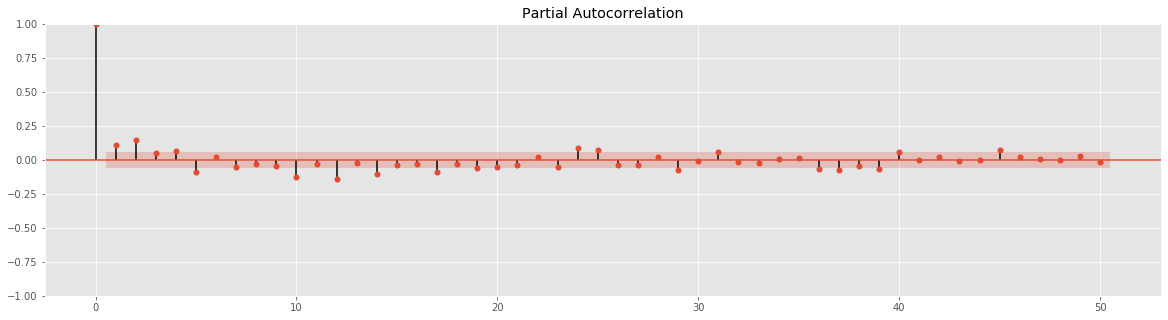

In [29]:
plot_acf(resid_dif, lags=50) # max_Q = 3
plot_pacf(resid_dif, lags=50); # max_P = 2

### 3.4) Кросс-валидация (1.5 балла)

Отберите на кросс-валидации наилучшую модель. Для прогноза фичи на необходимые 4 шага используйте AutoARIMA. 



In [30]:
# использую кросс-валидацию из предыдущего дз
class CustomCrossVal:
    def __init__(self, window_size = 100, step=30):
        
        self.window_size = window_size
        self.step = step
        
    def split(self, X):
        
        item = self.window_size
        lower_bound = 0
        
        for item in range(self.window_size, X.shape[0], self.step):
            
            train_index = np.arange(lower_bound, item - self.step)
            test_index = np.arange(item - self.step, item)
            
            lower_bound += self.step
            
            yield train_index, test_index 
            
def Custom_CrossVal_func(regressor, regressor_X, X_train, y_train, window_size, step):

    cv = CustomCrossVal(window_size=window_size, step = step)
    mae = []

    for i, j in cv.split(X_train):
    
        X_train_mod, y_train_mod = X_train.iloc[i], y_train.iloc[i]
        X_test_mod, y_test_mod = X_train.iloc[j], y_train.iloc[j]
    
        fh = ForecastingHorizon(list(range(1, step+1)))


        forecaster =  regressor
        forecaster.fit(y_train, X_train)


        forecaster_X = regressor_X
        forecaster_X.fit(X_train)

        X_pred = forecaster_X.predict(fh)
        pred = forecaster.predict(fh, X_pred)
        
        mae.append(mean_absolute_error(y_test_mod, pred))

        
    return print('Суммарная средняя абсолютная ошибка алгоритма:','%.2f'%np.sum(mae)), forecaster.summary()

In [31]:
stl = STL(ts.gas, period = 13)
res = stl.fit()
seas_strength = max(0, 1 - res.resid.std()**2 / (res.resid.std()**2 + res.seasonal.std()**2))
seas_strength # не используем сезонную разность

0.26794640696411365

In [32]:
kpss_test(ts.gas) # берем первую разность

KPSS Statistic: 1.1706722763741364
p-value: 0.01
num lags: 20
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [33]:
gas_diff = ts.gas.diff().dropna()
kpss_test(gas_diff) # d = 1

KPSS Statistic: 0.05345117225145597
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


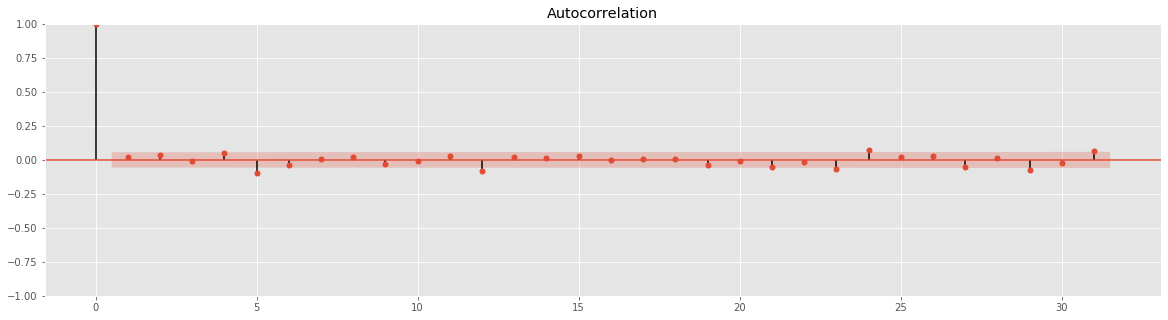

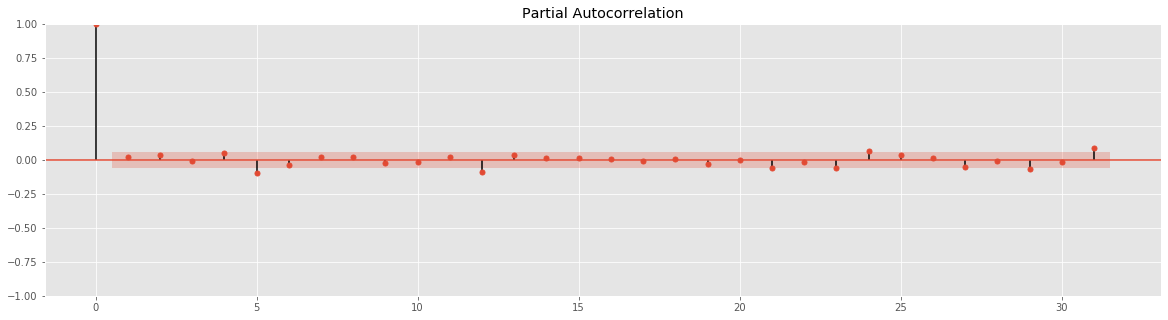

In [34]:
plot_acf(gas_diff) # q = 0, Q = 1
plot_pacf(gas_diff); # p = 1, P = 1

In [37]:
regressor_x = ARIMA(order = (1,1,0), seasonal_order=(1,0,1,13))
regressor = AutoARIMA(max_p=4, max_q=4)

Custom_CrossVal_func(regressor, regressor_x, gas_diff, ts.target[1:], window_size=150, step=4)

Суммарная средняя абсолютная ошибка алгоритма: 616.72


(None,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                 1212
 Model:               SARIMAX(2, 1, 2)   Log Likelihood               -4863.084
 Date:                Sat, 16 Apr 2022   AIC                           9738.167
 Time:                        20:22:16   BIC                           9768.762
 Sample:                    03-16-1997   HQIC                          9749.687
                          - 12-27-2020                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 gas           -2.4257      0.603     -4.022      0.000      -3.608      -1.244
 ar.L1          1.8721      0.013    147.090      0.000       1

### 3.5) Сравнение результатов (0.5 балла)

Добавьте к сравнению из пункта 2.4 лучшую модель из пункта 3.4. Получилось ли лучше?

SARIMA (2,1,2) уже была в сетке параметров и покзала ошибку выше чем SARIMA(2,1,1)[1,0,1,13]

## Скиньте мем (Бесценно)

Можно скидывать прямо в энитаск, в ноутбуках не всегда прикрепляются =(

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Рубрика "как вам домашка?"
Поделитесь, что вам понравилось, а что нет. Это важно